# Instruction

There are a total of 4 functions in this notebook


1.   Price prediction tool for Nasdaq data
2.   Price Prediction tool for VN data
3. Trading point suggestion tool for VN data
4. Portfolio management for VN data



Your stock data must have the below requirements. Check the sample file in the folder: `sample.csv`


1.   The file contains information for at least 90 days
2.   Information about the Stock Price (preferably Open price)
3. Information about the Trading Volume
4. Financial ratios: Price to Book, Price to Earning, ROA, ROE (only needed for portfilio management)



To use the functions, you need to modify the below things. This will be in it separate cell with a comment #MODIFY:


1.    The path to the desire file/folder (example: '/content/drive/MyDrive/folder/file/')
2. The datetime format of your data (example: if your data has dd-mm-YYYY format use %d-%m-%Y)
3.   The column index to fit with your the dataframes (example: column 1 in dataframe has index 0)
4. The financial ratios for your companies (only needed for portfilio management)
  

# Import libraries and Load models

In [21]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [22]:
conv_nas = load_model('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/conv_nas_model.h5')
gru_nas = load_model('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/gru_nas_model.h5')
vn_model = load_model('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/vn_model.h5')
tp7_model = load_model('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/tp7_model.h5')
tp30_model = load_model('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/tp30_model.h5')
ma5_model = load_model('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/ma5_model.h5')
ma22_model = load_model('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/models/ma22_model.h5')

# Price Prediction for Nasdaq

## Input data

In [48]:
#MODIFY THE PATH AND THE DATETIME FORMAT AS NEEDED
# Read CSV file from Google Drive
file_path = '/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/nasdaq/AAPL.csv'
df = pd.read_csv(file_path)

# Convert the date column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

In [49]:
# Get the last 90 days of data from the dataframe
data_last_90_days = df.iloc[-90:, :]
data_last_90_days.head()

,Date,Low,Open,Volume,High,Close,Adjusted Close
10500,2022-08-05,163.000000,163.210007,56697000,165.850006,165.350006,165.076172
10501,2022-08-08,164.199997,166.369995,60276900,167.809998,164.869995,164.596954
10502,2022-08-09,163.250000,164.020004,63135500,165.820007,164.919998,164.646866
10503,2022-08-10,166.899994,167.679993,70170500,169.339996,169.240005,168.959732
10504,2022-08-11,168.190002,170.059998,57149200,170.990005,168.490005,168.210968


In [50]:
#MODIFY THE COLUMN INDEX TO MATCH YOUR DATAFRAME
# Define the indices for Open and Volume columns
open_index = 2  # Replace with the actual index of the Open column in your dataset
volume_index = 3  # Replace with the actual index of the Volume column in your dataset

In [51]:
# Create the data feature
data_feature = [[], []]
for i in range(90):
    data_feature[0].append(data_last_90_days.iloc[i, open_index])  # Append Open price to first list
    data_feature[1].append(data_last_90_days.iloc[i, volume_index])  # Append Volume to second list

# Create the sample for predicting
sample = [np.array(data_feature[0]).reshape(90, 1),
          np.array(data_feature[1]).reshape(90, 1)]

In [52]:
# Convert from lists to Numpy arrays for reshaping purpose
sample = np.array(sample)
# Reshape the numpy array to fit the neural network input shape requirement
sample = sample.reshape(1, 2, 90, 1)

In [53]:
# MinMax normalize the data: x=(x-min(x)/(max(x)-min(x))
sample_norm = np.copy(sample)
#normalize feature 0
min_feature_0 = np.min(sample[0][0])
max_feature_0 = np.max(sample[0][0])
sample_norm[0][0] = (sample[0][0] - min_feature_0) / (max_feature_0 - min_feature_0)
#normalize feature 1
min_feature_1 = np.min(sample[0][1])
max_feature_1 = np.max(sample[0][1])
sample_norm[0][1] = (sample[0][1] - min_feature_1) / (max_feature_1 - min_feature_1)

## Get prediction

In [54]:
# Get prediction
predicted_price = conv_nas.predict(sample_norm)

#denorm the value
predicted_price_denorm = np.copy(predicted_price)
min_feature = np.min(sample[0][0])
max_feature = np.max(sample[0][0])
predicted_price_denorm = predicted_price[0] * (max_feature - min_feature) + min_feature

#print out prediction
print(f'Today price is: {sample[0][0][89][0]}')
print(f"The predicted stock value for tomorrow is: {predicted_price_denorm[0]}")

1/1 [==============================] - 0s 490ms/step
Today price is: 142.6999969482422
The predicted stock value for tomorrow is: 142.92970275878906


# Price Prediction for VN

## Input data

In [55]:
#MODIFY THE PATH AND THE DATETIME FORMAT AS NEEDED
# Read CSV file from Google Drive
file_path = '/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/vn/VCB-VNINDEX-History.csv'
df = pd.read_csv(file_path)

# Convert the date column to datetime format
df.rename(columns = {'TradingDate':'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [56]:
# Get the last 90 days of data from the dataframe
data_last_90_days = df.iloc[-90:, :]
data_last_90_days.head()

,Unnamed: 0,Open,High,Low,Close,Volume,Date
3323,3323,68000.0,68000.0,67300.0,67700.0,885675,2022-10-18
3324,3324,67900.0,68000.0,67300.0,67900.0,627787,2022-10-19
3325,3325,67900.0,70000.0,67100.0,69200.0,1517785,2022-10-20
3326,3326,69200.0,70700.0,68000.0,68000.0,1284429,2022-10-21
3327,3327,69500.0,69500.0,65800.0,68000.0,670658,2022-10-24


In [57]:
#MODIFY THE COLUMN INDEX TO MATCH YOUR DATAFRAME
# Define the indices for Open and Volume columns
open_index = 1  # Replace with the actual index of the Open column in your dataset
volume_index = 5  # Replace with the actual index of the Volume column in your dataset

In [58]:
# Create the data feature
data_feature = [[], []]
for i in range(90):
    data_feature[0].append(data_last_90_days.iloc[i, open_index])  # Append Open price to first list
    data_feature[1].append(data_last_90_days.iloc[i, volume_index])  # Append Volume to second list

# Create the sample for predicting
sample = [np.array(data_feature[0]).reshape(90, 1),
          np.array(data_feature[1]).reshape(90, 1)]

In [59]:
# Convert from lists to Numpy arrays for reshaping purpose
sample = np.array(sample)
# Reshape the numpy array to fit the neural network input shape requirement
sample = sample.reshape(1, 2, 90, 1)

In [60]:
# MinMax normalize the data: x=(x-min(x)/(max(x)-min(x))
sample_norm = np.copy(sample)
#normalize feature 0
min_feature_0 = np.min(sample[0][0])
max_feature_0 = np.max(sample[0][0])
sample_norm[0][0] = (sample[0][0] - min_feature_0) / (max_feature_0 - min_feature_0)
#normalize feature 1
min_feature_1 = np.min(sample[0][1])
max_feature_1 = np.max(sample[0][1])
sample_norm[0][1] = (sample[0][1] - min_feature_1) / (max_feature_1 - min_feature_1)

## Get prediction

In [61]:
# Get prediction
predicted_price = vn_model.predict(sample_norm)

#denorm the value
predicted_price_denorm = np.copy(predicted_price)
min_feature = np.min(sample[0][0])
max_feature = np.max(sample[0][0])
predicted_price_denorm = predicted_price[0] * (max_feature - min_feature) + min_feature

#print out prediction
print(f'Today price is: {sample[0][0][89][0]}')
print(f"The predicted stock value for tomorrow is: {predicted_price_denorm[0]}")

1/1 [==============================] - 0s 177ms/step
Today price is: 93100.0
The predicted stock value for tomorrow is: 92458.359375


# Trading Point - VN Data

## Input data

In [4]:
#MODIFY THE PATH AND THE DATETIME FORMAT AS NEEDED
# Read CSV file from Google Drive
file_path = '/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/vn/VCB-VNINDEX-History.csv'
df = pd.read_csv(file_path)

# Convert the date column to datetime format
df.rename(columns = {'TradingDate':'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
#create 2 Moving Average columns
df['MA 5 days'] = df['Open'].rolling(window=5).mean()
df['MA 22 days'] = df['Open'].rolling(window=22).mean()
df.fillna(method='bfill', inplace=True)  # Fill NaN values with the next row's value

In [5]:
# Get the last 90 days of data from the dataframe
data_last_90_days = df.iloc[-90:, :]
data_last_90_days.head()

,Unnamed: 0,Open,High,Low,Close,Volume,Date,MA 5 days,MA 22 days
3323,3323,68000.0,68000.0,67300.0,67700.0,885675,2022-10-18,66180.0,72068.181818
3324,3324,67900.0,68000.0,67300.0,67900.0,627787,2022-10-19,67160.0,71563.636364
3325,3325,67900.0,70000.0,67100.0,69200.0,1517785,2022-10-20,67920.0,71068.181818
3326,3326,69200.0,70700.0,68000.0,68000.0,1284429,2022-10-21,68060.0,70609.090909
3327,3327,69500.0,69500.0,65800.0,68000.0,670658,2022-10-24,68500.0,70236.363636


In [6]:
#MODIFY THE COLUMN INDEX TO MATCH YOUR DATAFRAME
# Define the indices for Open and Volume columns
open_index = 1  # Replace with the actual index of the Open column in your dataset
volume_index = 5  # Replace with the actual index of the Volume column in your dataset
ma5_index = 7 # Replace with the actual index of the MA5 column in your dataset
ma22_index = 8 # # Replace with the actual index of the MA22 column in your dataset

In [7]:
# Create the data feature
data_feature = [[], []]
ma5_feature =[[], []]
ma22_feature = [[], []]

for i in range(90):
    data_feature[0].append(data_last_90_days.iloc[i, open_index])  # Append Open price to first list
    data_feature[1].append(data_last_90_days.iloc[i, volume_index])  # Append Volume to second list

    ma5_feature[0].append(data_last_90_days.iloc[i, ma5_index])  # Append MA5 price to first list
    ma5_feature[1].append(data_last_90_days.iloc[i, volume_index])  # Append Volume to second list

    ma22_feature[0].append(data_last_90_days.iloc[i, ma22_index])  # Append MA22 price to first list
    ma22_feature[1].append(data_last_90_days.iloc[i, volume_index])  # Append Volume to second list

# Create the sample for predicting
sample = [np.array(data_feature[0]).reshape(90, 1),
          np.array(data_feature[1]).reshape(90, 1)]

sample_ma5 = [np.array(ma5_feature[0]).reshape(90, 1),
              np.array(ma5_feature[1]).reshape(90, 1)]
sample_ma22 = [np.array(ma22_feature[0]).reshape(90, 1),
          np.array(ma22_feature[1]).reshape(90, 1)]


In [8]:
# Convert from lists to Numpy arrays for reshaping purpose
sample = np.array(sample)
sample_ma5 = np.array(sample_ma5)
sample_ma22 = np.array(sample_ma22)
# Reshape the numpy array to fit the neural network input shape requirement
sample = sample.reshape(1, 2, 90, 1)
sample_ma5 = sample_ma5.reshape(1, 2, 90, 1)
sample_ma22 = sample_ma22.reshape(1, 2, 90, 1)

In [9]:
# MinMax normalize the data: x=(x-min(x)/(max(x)-min(x))
sample_norm = np.copy(sample)
#normalize feature 0
min_feature_0 = np.min(sample[0][0])
max_feature_0 = np.max(sample[0][0])
sample_norm[0][0] = (sample[0][0] - min_feature_0) / (max_feature_0 - min_feature_0)
#normalize feature 1
min_feature_1 = np.min(sample[0][1])
max_feature_1 = np.max(sample[0][1])
sample_norm[0][1] = (sample[0][1] - min_feature_1) / (max_feature_1 - min_feature_1)

In [10]:
# MinMax normalize the data: x=(x-min(x)/(max(x)-min(x))
sample_ma5_norm = np.copy(sample_ma5)
#normalize feature 0
min_feature_0 = np.min(sample_ma5[0][0])
max_feature_0 = np.max(sample_ma5[0][0])
sample_ma5_norm[0][0] = (sample_ma5[0][0] - min_feature_0) / (max_feature_0 - min_feature_0)
#normalize feature 1
min_feature_1 = np.min(sample_ma5[0][1])
max_feature_1 = np.max(sample_ma5[0][1])
sample_ma5_norm[0][1] = (sample_ma5[0][1] - min_feature_1) / (max_feature_1 - min_feature_1)

In [11]:
# MinMax normalize the data: x=(x-min(x)/(max(x)-min(x))
sample_ma22_norm = np.copy(sample_ma22)
#normalize feature 0
min_feature_0 = np.min(sample_ma22[0][0])
max_feature_0 = np.max(sample_ma22[0][0])
sample_ma22_norm[0][0] = (sample_ma22[0][0] - min_feature_0) / (max_feature_0 - min_feature_0)
#normalize feature 1
min_feature_1 = np.min(sample_ma22[0][1])
max_feature_1 = np.max(sample_ma22[0][1])
sample_ma22_norm[0][1] = (sample_ma22[0][1] - min_feature_1) / (max_feature_1 - min_feature_1)

## Get Prediction

In [12]:
# Get prediction
price_7 = tp7_model.predict(sample_norm)
price_30 = tp30_model.predict(sample_norm)
price_ma5 = ma5_model.predict(sample_ma5_norm)
price_ma22 = ma22_model.predict(sample_ma22_norm)

1/1 [==============================] - 0s 164ms/step


## 7 days suggestion

### Prediction for 7 days

In [13]:
#denorm the value
price_7_denorm = np.copy(price_7)
min_feature = np.min(sample[0][0])
max_feature = np.max(sample[0][0])
price_7_denorm = price_7[0] * (max_feature - min_feature) + min_feature

#print out prediction
print(f'Today price is: {sample[0][0][89][0]}')
print("Predicted stock values for the next 7 days:")
for i, price in enumerate(price_7_denorm):
    print(f"Day {i+1}: {price}")

Today price is: 93100.0
Predicted stock values for the next 7 days:
Day 1: 93586.171875
Day 2: 93511.34375
Day 3: 93172.4453125
Day 4: 93096.296875
Day 5: 94676.0859375
Day 6: 94012.9453125
Day 7: 93786.4375


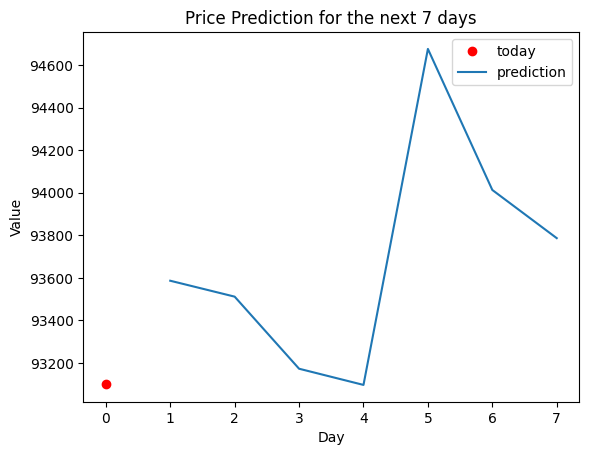

In [14]:
#Plot the price for day t and the prediction
plt.plot([0], sample[0][0][89], 'ro', label='today')
plt.plot(range(1, len(price_7_denorm) + 1), price_7_denorm, label='prediction')
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Price Prediction for the next 7 days')
plt.legend()
plt.show()

### Buying Point

In [15]:
#determine the buying point base on return on investment
t_price = sample[0][0][89][0] #today's price is the last day in the sample, index = window_size - 1
highest_price = price_7_denorm.max() #the highest price in the next 7 days
highest_day = np.argmax(price_7_denorm)
roi = (highest_price - t_price)/t_price
if roi >= 0:
  print(f'If we buy the stock today at {t_price}, there is a chance that the price can increase to {highest_price} which give us a {round(roi*100, 2)}% return on investment after {highest_day + 1} days.')
else:
  print(f'It might not be best to buy the stock today at {t_price} because the price will decrease over the next 7 days.')

If we buy the stock today at 93100.0, there is a chance that the price can increase to 94676.0859375 which give us a 1.69% return on investment after 5 days.


### Selling Point

In [16]:
#determine the selling point
t_price = sample[0][0][89][0] #today's price is the last day in the sample, index = window_size - 1
highest_price = price_7_denorm.max() #the highest price in the next 7 days
highest_day = np.argmax(price_7_denorm)
roi = (highest_price - t_price)/t_price
if highest_price > t_price:
  print(f'We can consider waiting because after {highest_day + 1} days, there is a chance that the price will increase by {round(roi*100, 2)}% and will be highest at {highest_price}')
else:
  print(f'We can consider selling the stock today at {t_price} because the price will decrease over the next 7 days')

We can consider waiting because after 5 days, there is a chance that the price will increase by 1.69% and will be highest at 94676.0859375


## Moving Average Signal

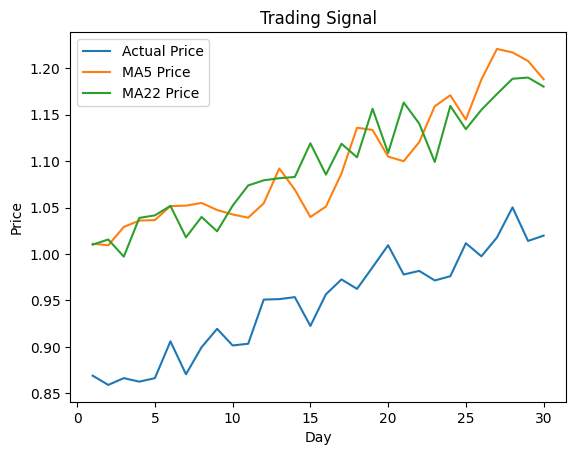

In [18]:
#Plot the trend lines for the next 30 days
days = range(1, len(price_30[0]) + 1)

plt.plot(days, price_30[0], label='Actual Price')
plt.plot(days, price_ma5[0], label='MA5 Price')
plt.plot(days, price_ma22[0], label='MA22 Price')

plt.xlabel('Day')
plt.ylabel('Price')
plt.title('Trading Signal')
plt.legend()

plt.show()

# Portfolio Management - VN Data

## Expected return and risk

In [23]:
#MODIFY THE FINANCIAL RATIO FOR YOUR COMPANIES
# Define Financial Ratio for each company
pe = {'ACB': 6.2, 'BID': 12.7, 'CTG': 8, 'LPB': 5.5, 'MBB': 4.6, 'NAB': 4.6,
 'BAB': 15.8, 'STB': 9.5, 'TCB': 4.8,'TPB': 6.1, 'VCB': 14.7}

pb = {'ACB': 1.5, 'BID': 2.2, 'CTG': 1.3, 'LPB': 1, 'MBB': 1, 'NAB': 0.6,
 'BAB': 1.4, 'STB': 1.2, 'TCB': 0.8, 'TPB': 1.2, 'VCB': 3.2}

roe = {'ACB': 0.265, 'BID': 0.199, 'CTG': 0.169, 'LPB': 0.221, 'MBB': 0.258, 'NAB': 0.171,
 'BAB': 0.091, 'STB': 0.138, 'TCB': 0.197, 'TPB': 0.215, 'VCB': 0.24}

roa = {'ACB': 0.024, 'BID': 0.009, 'CTG': 0.01, 'LPB': 0.221, 'MBB': 0.026, 'NAB': 0.011,
 'BAB': 0.007, 'STB': 0.009, 'TCB': 0.032, 'TPB': 0.02, 'VCB': 0.019}

In [24]:
#MODIFY THE PATH AND THE DATETIME FORMAT AS NEEDED
#the path should be to a folder containing multiple companies
#store the dataframes in dictionary
file_path = os.chdir('/content/drive/MyDrive/Spring 2023/Deep Learning/Final Project/vn/test data')
data_dict = {}
for filename in os.listdir(file_path):
  data = pd.read_csv(filename)
  data = data.reset_index(drop=True)
  data_dict[filename[:3]] = data  # Read the CSV file and store it in the dictionary

In [25]:
#compute the daily return for each company
for company in data_dict:
  data_dict[company]['Daily Return'] = data_dict[company]['Open'].pct_change()

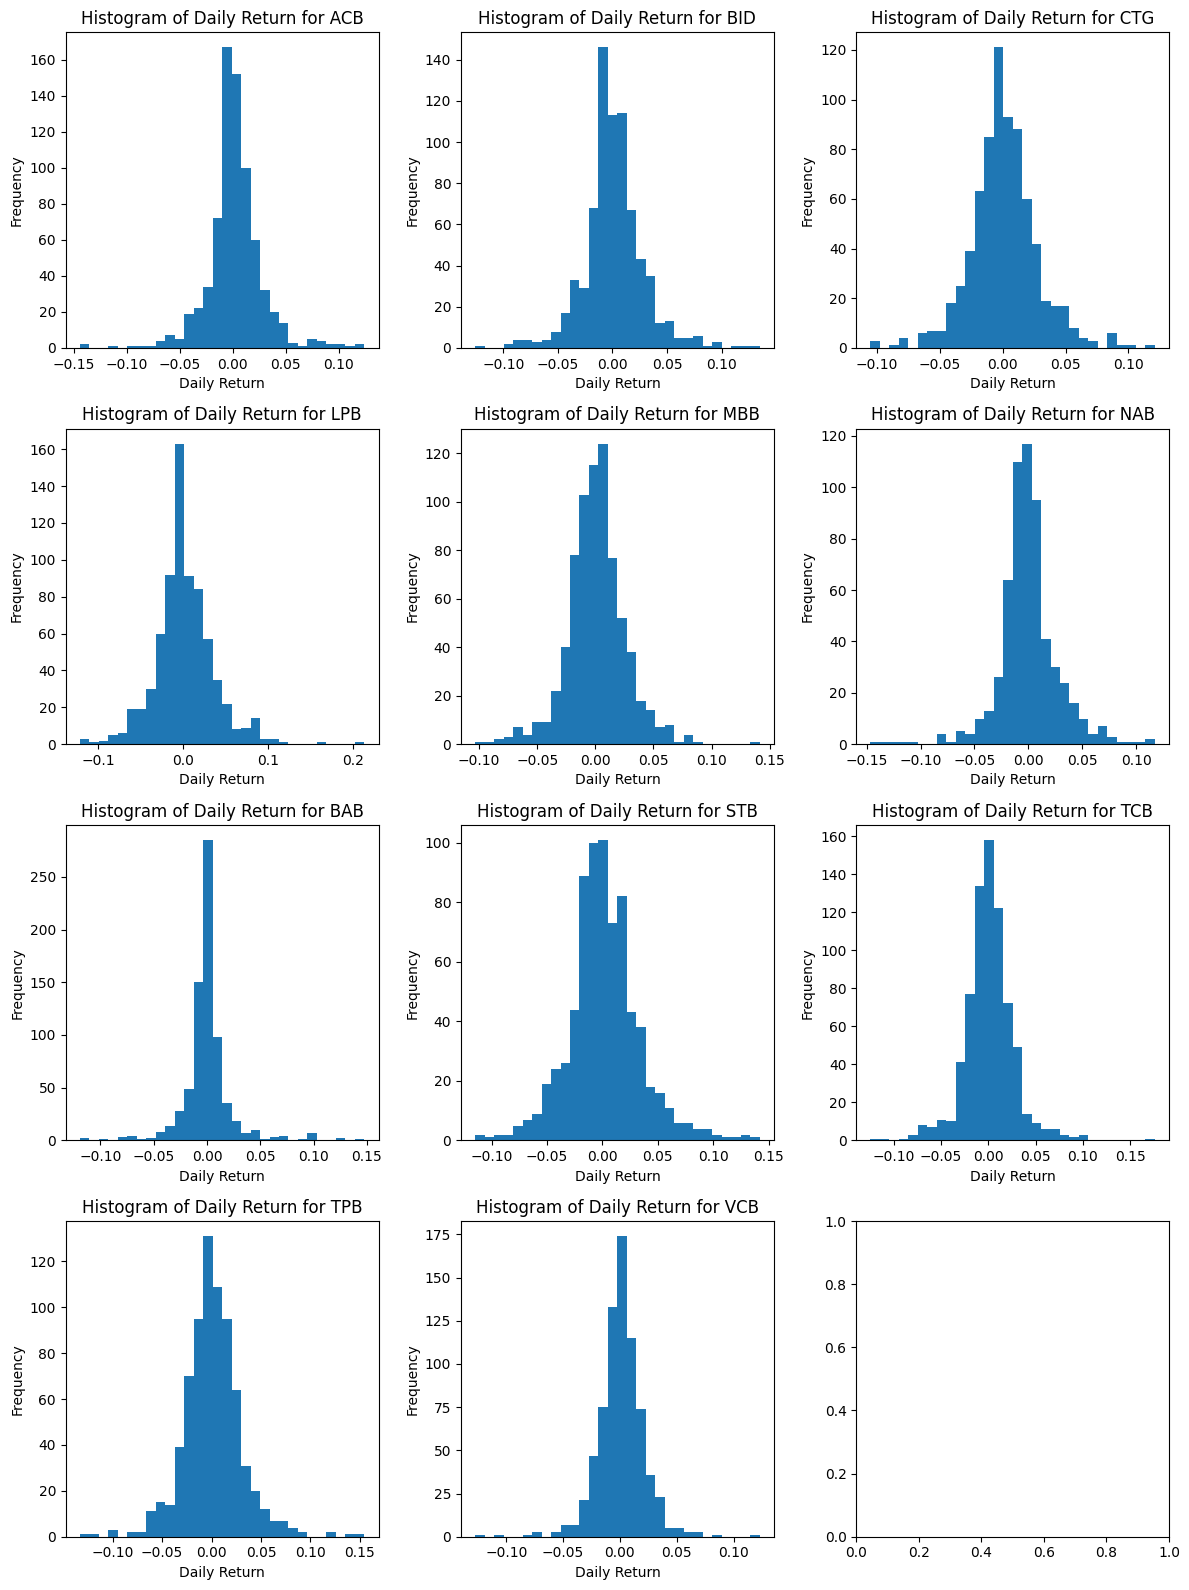

In [26]:
#Plot the histograms of daily return for each company
num_rows = 4
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 16))

companies = list(data_dict.keys())
for i, company in enumerate(companies):
  row = i // num_cols
  col = i % num_cols

  data_frame = data_dict[company]
  daily_returns = data_frame['Daily Return']

  axes[row, col].hist(daily_returns, bins=30)
  axes[row, col].set_title(f'Histogram of Daily Return for {company}')
  axes[row, col].set_xlabel('Daily Return')
  axes[row, col].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [27]:
#compute the average daily return and standard deviation of daily return for each company and store in dictionary
average_daily_returns_exp = {}
sd_daily_returns_exp = {}

for company, data_frame in data_dict.items():
    daily_returns = data_frame['Daily Return']
    average_return = daily_returns.mean()
    sd_deviation = daily_returns.std()
    average_daily_returns_exp[company] = average_return
    sd_daily_returns_exp[company] = sd_deviation

print('Average Daily Return:')
for company, average_return in average_daily_returns_exp.items():
    sd_deviation = sd_daily_returns_exp[company]
    print(f"{company}: Average Daily Return = {average_return:.6f}%, Standard Deviation = {sd_deviation:.6f}")

Average Daily Return:
ACB: Average Daily Return = 0.001461%, Standard Deviation = 0.026388
BID: Average Daily Return = 0.001041%, Standard Deviation = 0.027794
CTG: Average Daily Return = 0.001080%, Standard Deviation = 0.026982
LPB: Average Daily Return = 0.002103%, Standard Deviation = 0.034502
MBB: Average Daily Return = 0.001178%, Standard Deviation = 0.025312
NAB: Average Daily Return = -0.000116%, Standard Deviation = 0.028143
BAB: Average Daily Return = 0.000249%, Standard Deviation = 0.022735
STB: Average Daily Return = 0.001661%, Standard Deviation = 0.032732
TCB: Average Daily Return = 0.000879%, Standard Deviation = 0.026483
TPB: Average Daily Return = 0.001343%, Standard Deviation = 0.029386
VCB: Average Daily Return = 0.000938%, Standard Deviation = 0.020642


In [28]:
#compute the average monthly return and standard deviation of monthly return for each company and store in dictionary
average_monthly_returns_exp = {}
sd_monthly_returns_exp = {}
for company, data_frame in data_dict.items():
    data_frame['Date'] = pd.to_datetime(data_frame['Date'])
    data_frame.set_index('Date', inplace=True)
    daily_returns = data_frame['Daily Return']
    monthly_returns = daily_returns.resample('M').sum()
    sd_deviation = monthly_returns.std()
    average_monthly_return = monthly_returns.mean()
    average_monthly_returns_exp[company] = average_monthly_return
    sd_monthly_returns_exp[company] = sd_deviation

print("Average Monthly Returns:")
for company, average_monthly_return in average_monthly_returns_exp.items():
  sd_deviation = sd_monthly_returns_exp[company]
  print(f"{company}: Average Monthly Return = {average_monthly_return:.6f}%, Standard Deviation = {sd_deviation:.6f}")

Average Monthly Returns:
ACB: Average Monthly Return = 0.029785%, Standard Deviation = 0.093299
BID: Average Monthly Return = 0.021380%, Standard Deviation = 0.113702
CTG: Average Monthly Return = 0.022168%, Standard Deviation = 0.117790
LPB: Average Monthly Return = 0.042581%, Standard Deviation = 0.135168
MBB: Average Monthly Return = 0.024173%, Standard Deviation = 0.108262
NAB: Average Monthly Return = -0.002378%, Standard Deviation = 0.134189
BAB: Average Monthly Return = 0.005077%, Standard Deviation = 0.084601
STB: Average Monthly Return = 0.034089%, Standard Deviation = 0.134802
TCB: Average Monthly Return = 0.018039%, Standard Deviation = 0.120859
TPB: Average Monthly Return = 0.027578%, Standard Deviation = 0.114323
VCB: Average Monthly Return = 0.019252%, Standard Deviation = 0.089071


## Predict return

### Generate prediction

In [29]:
#create a dictionary to store only the last 90 days data
data_last_90_dict = {}
for company, data_frame in data_dict.items():
    last_90_days = data_frame.iloc[-90:, :]
    data_last_90_dict[company] = last_90_days

In [30]:
# Define the indices for Open and Volume columns
open_index = 2  # Replace with the actual index of the Open column in your dataset
volume_index = 6  # Replace with the actual index of the Volume column in your dataset

# Create a dictionary to store the samples for each company
samples_dict = {}

# Iterate over each company in data_last_90_dict
for company, data_frame in data_last_90_dict.items():
    # Create the data feature
    data_feature = [[], []]
    for i in range(90):
        data_feature[0].append(data_frame.iloc[i, open_index])  # Append Open price to first list
        data_feature[1].append(data_frame.iloc[i, volume_index])  # Append Volume to second list

    # Create the sample for predicting
    sample = [np.array(data_feature[0]).reshape(90, 1),
              np.array(data_feature[1]).reshape(90, 1)]

    # Store the sample in the dictionary
    samples_dict[company] = sample


In [31]:
normalized_samples_dict = {}

for company, sample in samples_dict.items():
    # MinMax normalize the data: x=(x-min(x)/(max(x)-min(x))
    sample_norm = np.copy(sample)
    # Normalize feature 0
    min_feature_0 = np.min(sample[0])
    max_feature_0 = np.max(sample[0])
    sample_norm[0] = (sample[0] - min_feature_0) / (max_feature_0 - min_feature_0)
    # Normalize feature 1
    min_feature_1 = np.min(sample[1])
    max_feature_1 = np.max(sample[1])
    sample_norm[1] = (sample[1] - min_feature_1) / (max_feature_1 - min_feature_1)
    sample_norm = np.array(sample_norm)
    sample_norm = np.reshape(sample_norm, (1, 2, 90, 1))
    # Store the normalized sample in the dictionary
    normalized_samples_dict[company] = sample_norm


In [32]:
#use the tp7 model to make prediction for each company and store in dictionary
prediction_dict = {}

for company, feature in normalized_samples_dict.items():
  prediction = tp7_model.predict(feature)
  prediction_dict[company] = prediction

1/1 [==============================] - 0s 65ms/step


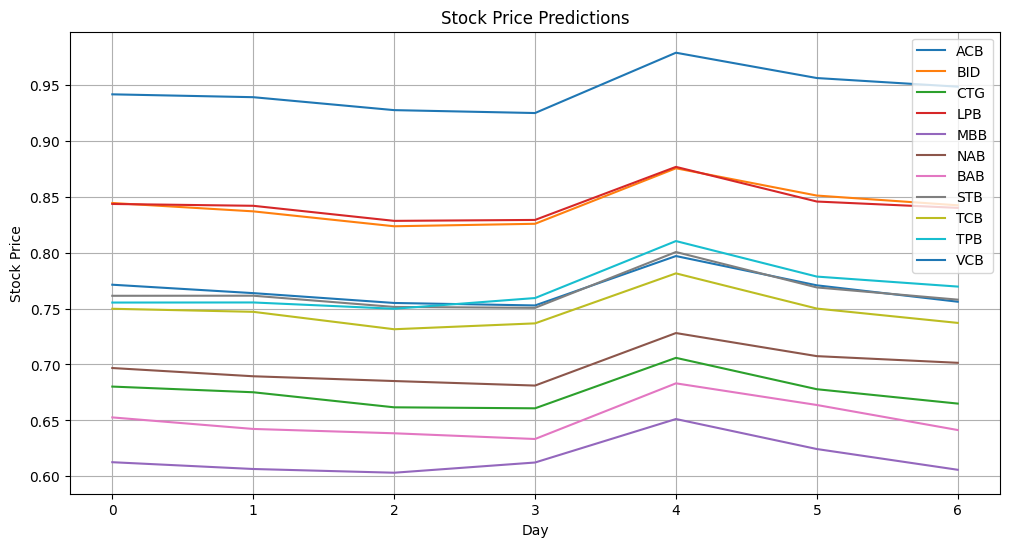

In [33]:
# Plotting line chart for each company
plt.figure(figsize=(12, 6))

for company, prediction in prediction_dict.items():
    plt.plot(prediction[0], label=company)

plt.title('Stock Price Predictions')
plt.xlabel('Day')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

### Display predicted return

In [34]:
average_daily_returns_pre = {}

for company, prediction in prediction_dict.items():
    # Calculate the daily returns
    returns = []
    for i in range(len(prediction[0]) - 1):
        daily_return = (prediction[0][i + 1] - prediction[0][i]) / prediction[0][i]
        returns.append(daily_return)

    # Calculate the average daily return
    average_return = np.mean(returns)
    average_daily_returns_pre[company] = average_return

print('Predicted Average Daily Return:')
for company, average_return in average_daily_returns_pre.items():
    print(f"{company}: Average Daily Return = {average_return:.6f}%")

Predicted Average Daily Return:
ACB: Average Daily Return = -0.002898%
BID: Average Daily Return = -0.000016%
CTG: Average Daily Return = -0.003192%
LPB: Average Daily Return = -0.000298%
MBB: Average Daily Return = -0.001279%
NAB: Average Daily Return = 0.001580%
BAB: Average Daily Return = -0.002222%
STB: Average Daily Return = -0.000237%
TCB: Average Daily Return = -0.002330%
TPB: Average Daily Return = 0.003641%
VCB: Average Daily Return = 0.001543%


## Ranking

In [35]:
def normalize_dict_values(dictionary, min_range, max_range):
    min_value = min(dictionary.values())
    max_value = max(dictionary.values())
    
    normalized_dict = {}
    for key, value in dictionary.items():
        normalized_value = ((value - min_value) / (max_value - min_value)) * (max_range - min_range) + min_range
        normalized_dict[key] = normalized_value
    
    return normalized_dict

In [36]:
norm_pe = normalize_dict_values(pe, 1, 2)
norm_pb = normalize_dict_values(pb, 1, 2)
norm_roa = normalize_dict_values(roa, 1, 2)
norm_roe = normalize_dict_values(roe, 1, 2)

norm_average_daily_returns_pre = normalize_dict_values(average_daily_returns_pre, 1, 2)
norm_average_monthly_returns_exp = normalize_dict_values(average_monthly_returns_exp, 1, 2)
norm_sd_daily_returns_exp = normalize_dict_values(sd_daily_returns_exp, 1,2)
norm_sd_monthly_returns_exp = normalize_dict_values(sd_monthly_returns_exp, 1,2)
norm_average_daily_returns_exp = normalize_dict_values(average_daily_returns_exp, 1, 2)

In [37]:
metric_scores = {}

for company, avg_return_pre in norm_average_daily_returns_pre.items():
    monthly_return = norm_average_monthly_returns_exp[company]
    std_daily_exp = norm_sd_daily_returns_exp[company]
    std_monthly_exp = norm_sd_monthly_returns_exp[company]
    avg_daily_returns_exp = norm_average_daily_returns_exp[company]
    pb_ = norm_pb[company]
    pe_ = norm_pb[company]
    roe_ = norm_roe[company]
    roa_ = norm_roa[company]
    # Calculate the metric score
    metric_score = ((0.5*avg_return_pre) + (0.15*(1/std_daily_exp)) + (0.05*(1/std_monthly_exp))
                    + (0.15*avg_daily_returns_exp) + (0.05*monthly_return) + (0.025*(1/pb_)) + (0.025*(1/pe_)) + (0.025*roa_) + (0.025*roe_))

    # Store the metric score for the company
    metric_scores[company] = metric_score

# Sort the metric scores in descending order
sorted_metric_scores_pre= {k: v for k, v in sorted(metric_scores.items(), key=lambda item: item[1], reverse=True)}

# Print the ranked companies based on the metric score
print("Ranked:    Metric Score:     Predicted Daily Return")
for rank, (company, score) in enumerate(sorted_metric_scores_pre.items(), 1):
  print(f"{rank}. {company}:       {score:.6f}    {average_daily_returns_pre[company]:.6f}%")


Ranked:    Metric Score:     Predicted Daily Return
1. TPB:       1.565408    0.003641%
2. VCB:       1.435534    0.001543%
3. LPB:       1.348777    -0.000298%
4. NAB:       1.283718    0.001580%
5. STB:       1.279716    -0.000237%
6. BID:       1.264466    -0.000016%
7. MBB:       1.222731    -0.001279%
8. ACB:       1.126697    -0.002898%
9. TCB:       1.102213    -0.002330%
10. BAB:       1.072464    -0.002222%
11. CTG:       1.042208    -0.003192%


In [45]:
# Print the top 3 ranked companies based on the metric score
print("Top 3 Ranked Companies that you can consider holding:")
print("Ranked:    Metric Score:     Predicted Daily Return")
for rank, (company, score) in enumerate(sorted_metric_scores_pre.items(), 1):
    if rank > 3:
        break
    print(f"{rank}. {company}:       {score:.6f}    {average_daily_returns_pre[company]:.6f}%")

Top 3 Ranked Companies that you can consider holding:
Ranked:    Metric Score:     Predicted Daily Return
1. TPB:       1.565408    0.003641%
2. VCB:       1.435534    0.001543%
3. LPB:       1.348777    -0.000298%


In [44]:
# Get the last 3 companies
last_3_companies = list(sorted_metric_scores_pre.keys())[-3:]

# Print the last 3 ranked companies based on the metric score
print("Last 3 Ranked Companies that you can consider avoiding:")
print("Ranked:    Metric Score:     Predicted Daily Return")
for rank, company in enumerate(last_3_companies, 1):
    score = sorted_metric_scores_pre[company]
    print(f"{rank}. {company}:       {score:.6f}    {average_daily_returns_pre[company]:.6f}%")


Last 3 Ranked Companies that you can consider avoiding:
Ranked:    Metric Score:     Predicted Daily Return
1. TCB:       1.102213    -0.002330%
2. BAB:       1.072464    -0.002222%
3. CTG:       1.042208    -0.003192%


This is the ranking of the companies from the list. You can consider pick out companies from the list that best fit your preference.